In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#current model

# Install libraries

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 36.3 MB/s 


In [ ]:
pip install ffmpeg moviepy

In [ ]:
!pip install keras-layer-normalization

In [ ]:
pip install tensorflow-addons

In [ ]:
import keras
import tensorflow as tf
import keras_tuner as kt
import tensorflow_addons as tfa
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.layers import LSTM, Flatten, Bidirectional, Dense, Permute, multiply,Dropout, LayerNormalization,GaussianNoise, GaussianDropout ,GlobalAveragePooling1D,BatchNormalization
from keras_layer_normalization import LayerNormalization
import numpy as np
import h5py
import math
from pandas import read_json
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
from keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Bidirectional, Permute, multiply
from keras.layers.recurrent import LSTM
from keras.callbacks import CSVLogger
from keras.models import Sequential, Model, load_model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
#from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import os
import time
import numpy as np
import cv2
import moviepy.editor as mp

# Set Config


In [ ]:
class Config:
  DATASET_PATH ="/content/drive/MyDrive/TVSum.h5"
  BATCH_SIZE = 1
  EPOCHS = 120
  MODEL_PATH = "/content/drive/MyDrive/summe/models/summary_TVSum_model.hdf5"

# Load dataset

In [ ]:
# Load dataset
def Load_dataset():
  dataset = h5py.File(Config.DATASET_PATH, 'r')
  num_videos = len(dataset.keys())
  print(num_videos)

  SPLIT = "/content/drive/MyDrive/TVSum_splits.json"
  SPLIT_ID = 0
  splits = read_json(SPLIT)
  TEST = False
  if not TEST:
      assert SPLIT_ID < len(splits), "split_id (got {}) exceeds {}".format(SPLIT_ID, len(splits ))
      train_keys = splits["train_keys"][0]
      test_keys = splits["test_keys"][0]
      print("# total videos {}. # train videos {}. # test videos {}.".format(num_videos, len(train_keys), len(test_keys)))

  return dataset, train_keys, test_keys

dataset, train_keys, test_keys = Load_dataset()

50
# total videos 50. # train videos 40. # test videos 10.


In [ ]:
def Load_dataset_for_single():
  dataset = h5py.File(Config.DATASET_PATH, 'r')
  return dataset
  
dataset = Load_dataset_for_single()

#Auto tuner

In [ ]:
def reg_wrapper(type, value):
    if type == 'l2':
        return regularizers.l2(value)
    if type == 'l1':
        return regularizers.l1(value)

In [ ]:
def model_builder(hp):
  
  model = Sequential()
  
  model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
  model.add(LayerNormalization())
  model.add(keras.layers.GaussianNoise(0.2))
  model.add(keras.layers.GaussianDropout(0.2))
  model.add(Bidirectional(LSTM(units=128, return_sequences=True )))
  model.add(keras.layers.GaussianNoise(0.2))
  model.add(keras.layers.GaussianDropout(0.1))
  model.add(LayerNormalization())
  reg1 = reg_wrapper(hp.Choice('type', ['l1', 'l2', 'l1_l2']), hp.Choice('reg_value1', [0.01,0.001,0.1,0.005,0.05]))
  reg2 = reg_wrapper(hp.Choice('type2', ['l1', 'l2', 'l1_l2']), hp.Choice('reg_value2', [0.01,0.001,0.1,0.005,0.05]))
  model.add(Dense(hp.Int('hidden_size', 256, 1024, step=10, default=50),activation="relu", kernel_initializer = tf.keras.initializers.GlorotUniform() ,kernel_regularizer=reg1))
  model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
  model.add(TimeDistributed(Dense(1,activation="relu", kernel_initializer = tf.keras.initializers.GlorotUniform() ,kernel_regularizer=reg2)))

  model.compile(loss='cosine_similarity', optimizer= tf.keras.optimizers.Nadam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), metrics=["accuracy"])

  return model

In [ ]:
def train_prepare(dataset, train_keys):
  indices = np.arange(len(train_keys))
  count = 0
  np.random.shuffle(indices)
  
  data_seq = np.zeros((30,400,512))
  for idx in indices:
    key = train_keys[idx]
    seq = dataset[key]['features'][...]
    seq_split = np.vsplit(seq,[400])  
    if seq_split[1].shape[0] != 0 :
      seq_split[1]= np.resize(seq_split[1],(400,512))
      data_seq[count] = seq_split[0]
      count += 1
      data_seq[count] = seq_split[1]
      count += 1
      
    else:
      seq_split[0]= np.resize(seq_split[0],(400,512))
      data_seq[count] = seq_split[0]
      count += 1
  
  return data_seq

train_set = train_prepare(dataset, train_keys)

In [ ]:
tuner = kt.RandomSearch(model_builder,
                     objective='accuracy',
                     max_trials=5,project_name='hyperband_tuner4')

In [ ]:
tuner.search(train_set, train_set, epochs=50)

model=tuner.get_best_models(num_models=1)[0]
model.fit(train_set,train_set, epochs=50)
# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
model.save("/content/drive/MyDrive/umodels/hyper_model.hdf5")

TypeError: ignored

# Train model(normal)


In [ ]:
def get_model(train_set,reload_model=True):
  
  #callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
  model = Sequential()
  
  if reload_model:
    if os.path.isfile(Config.MODEL_PATH):
      model = load_model(Config.MODEL_PATH)
      model.fit(train_set,train_set,batch_size=1, epochs=Config.EPOCHS, shuffle=False)
      model.save(Config.MODEL_PATH)
      return model
  
  
  model.add(Bidirectional(LSTM(units=256, return_sequences=True,
                          input_shape=(train_set.shape[1],train_set.shape[2] ))))
  model.add(LayerNormalization())
  model.add(keras.layers.GaussianNoise(0.2))
  model.add(keras.layers.GaussianDropout(0.2))
  model.add(Bidirectional(LSTM(units=128, return_sequences=False )))
  model.add(keras.layers.GaussianNoise(0.2))
  model.add(keras.layers.GaussianDropout(0.2))
  model.add(LayerNormalization())
  model.add(Dense(886,activation="relu", kernel_initializer = tf.keras.initializers.GlorotUniform() ,kernel_regularizer=regularizers.l1_l2(0.005)))
  model.add(Dropout(0.2))
  model.add(Dense(512,activation="relu", kernel_initializer = tf.keras.initializers.GlorotUniform() ,kernel_regularizer=regularizers.l1_l2(0.1)))
  model.compile(loss='cosine_similarity', optimizer= tf.keras.optimizers.Nadam(), metrics=["accuracy"])
  model.fit(train_set,train_set,batch_size=Config.BATCH_SIZE, epochs=50, shuffle=False)
  model.save(Config.MODEL_PATH)
  return model

In [ ]:
def train_all(dataset, train_keys):
  indices = np.arange(len(train_keys))
  count = 0
  seq_size = 0
  np.random.shuffle(indices)
  for idx in indices:
    key = train_keys[idx]
    seq = dataset[key]['features'][...]
    seq_size += int(seq.shape[0] / 400) + 1


  data_seq = np.zeros((seq_size,400,512))
  for idx in indices:
    key = train_keys[idx]
    seq = dataset[key]['features'][...]
    seq_split = np.vsplit(seq,[400])  
    if seq_split[1].shape[0] != 0 :
      seq_split[1]= np.resize(seq_split[1],(400,512))
      data_seq[count] = seq_split[0]
      count += 1
      data_seq[count] = seq_split[1]
      count += 1
      
    else:
      seq_split[0]= np.resize(seq_split[0],(400,512))
      data_seq[count] = seq_split[0]
      count += 1
  model = get_model(data_seq,False)
  
  return model

model = train_all(dataset, train_keys)

ValueError: ignored

#Train model with attention

In [ ]:
def attention_block(inputs, time_steps):
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul

In [ ]:
def get_seq_model(train_set):
  frame_features_input = keras.Input((400,512))
  lstm_out = Bidirectional(LSTM(units=256,name="lstm1", return_sequences=True, input_shape=(train_set.shape[1],train_set.shape[2]) ))(frame_features_input)
  lstm_out = Bidirectional(LSTM(units=128, name="lstm2", return_sequences=True ))(lstm_out)

  lstm_out = GaussianNoise(0.2)(lstm_out)
  lstm_out = GaussianDropout(0.1)(lstm_out)
  lstm_out = LayerNormalization()(lstm_out)

  print(lstm_out.shape)
  attention_mul = attention_block(lstm_out, lstm_out.shape[1])
  attention_mul = GlobalAveragePooling1D()(attention_mul)

  x = Dense(1024,name="dense1",activation="relu", kernel_initializer = tf.keras.initializers.GlorotUniform() ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(attention_mul)
  x = Dropout(0.2)(x)
  x = TimeDistributed(Dense(1,activation="softmax", kernel_initializer = tf.keras.initializers.GlorotUniform() ,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))(x)
  
  model = Model(frame_features_input, x)
  model.compile(loss='cosine_similarity', optimizer= tf.keras.optimizers.Nadam() , metrics=["accuracy"])
  model.fit(train_set,train_set,batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
  return model

In [ ]:
def train_attention_model(dataset, train_keys):
  indices = np.arange(len(train_keys))
  count = 0
  np.random.shuffle(indices)
  
  data_seq = np.zeros((30,400,512))
  for idx in indices:
    key = train_keys[idx]
    seq = dataset[key]['features'][...]
    seq_split = np.vsplit(seq,[400])  
    if seq_split[1].shape[0] != 0 :
      seq_split[1]= np.resize(seq_split[1],(400,512))
      data_seq[count] = seq_split[0]
      count += 1
      data_seq[count] = seq_split[1]
      count += 1
      
    else:
      seq_split[0]= np.resize(seq_split[0],(400,512))
      data_seq[count] = seq_split[0]
      count += 1
  
  model = get_seq_model(data_seq)
  
  return model

model = train_attention_model(dataset,train_keys)

# Vsum methods

In [ ]:
def knapsack_dp(values,weights,n_items,capacity,return_all=False):
    check_inputs(values,weights,n_items,capacity)

    table = np.zeros((n_items+1,capacity+1),dtype=np.float32)
    keep = np.zeros((n_items+1,capacity+1),dtype=np.float32)

    for i in range(1,n_items+1):
        for w in range(0,capacity+1):
            wi = weights[i-1] # weight of current item
            vi = values[i-1] # value of current item
            if (wi <= w) and (vi + table[i-1,w-wi] > table[i-1,w]):
                table[i,w] = vi + table[i-1,w-wi]
                keep[i,w] = 1
            else:
                table[i,w] = table[i-1,w]

    picks = []
    K = capacity

    for i in range(n_items,0,-1):
        if keep[i,K] == 1:
            picks.append(i)
            K -= weights[i-1]

    picks.sort()
    picks = [x-1 for x in picks] # change to 0-index

    if return_all:
        max_val = table[n_items,capacity]
        return picks,max_val
    return picks

def check_inputs(values, weights, n_items, capacity):
    # check variable type
    assert(isinstance(values,list))
    assert(isinstance(weights,list))
    assert(isinstance(n_items,int))
    assert(isinstance(capacity,int))
    # check value type
    assert(all(isinstance(val,int) or isinstance(val,float) for val in values))
    assert(all(isinstance(val,int) for val in weights))
    # check validity of value
    assert(all(val >= 0 for val in weights))
    assert(n_items > 0)
    assert(capacity > 0)

In [ ]:
def generate_summary(ypred, cps, n_frames, nfps, positions, proportion=0.15, method='knapsack'):
    """
        Generate keyshot-based video summary. i.e. a binary vector

    Args:
        ypred: predicted importance scores.
        cps: change points, 2D matrix, each row contains a segment.
        n_frames: original number of frames.
        nfps: number of frames per segment.
        positions: positions of subsampled frames in the original video.
        proportion: length of video summary (compared to original video length).
        method: defines how shots are selected, ['knapsack', 'rank'].

    """

    n_segs = cps.shape[0]

    # Frame Score
    frame_scores = np.zeros((n_frames), dtype=np.float32)
    if positions.dtype != int:
        positions = positions.astype(np.int32)

    if positions[-1] != n_frames:
        positions = np.concatenate([positions, [n_frames]])

    for idx in range(len(positions) - 1):
        pos_cur, pos_next = positions[idx], positions[idx+1]

        if idx >= len(ypred):
            frame_scores[pos_cur:pos_next] = 0
        else:
            frame_scores[pos_cur:pos_next] = ypred[idx]

    # Segment Score
    seg_score = []
    for seg_idx in range(n_segs):
        pos_start, pos_end = int(cps[seg_idx, 0]), int(cps[seg_idx, 1]+1)
        scores = frame_scores[pos_start: pos_end]
        seg_score.append(float(scores.mean()))

    limits = int(math.floor(n_frames * proportion))

    if method == 'knapsack':
        picks = knapsack_dp(seg_score, nfps, n_segs, limits)
    elif method == 'rank':
        order = np.argsort(seg_score)[::-1].tolist()
        picks = []
        total_len = 0

        for idx in order:
            if total_len + nfps[idx] < limits:
                picks.append(idx)
                total_len += nfps[idx]

    else:
        raise KeyError("Unknown method {}".format(method))

    summary = np.zeros((1), dtype=np.float32) # this element should be deleted
    for seg_idx in range(n_segs):
        nf = nfps[seg_idx]
        if seg_idx in picks:
            tmp = np.ones((nf), dtype=np.float32)
        else:
            tmp = np.zeros((nf), dtype=np.float32)

        summary = np.concatenate((summary, tmp))

    summary = np.delete(summary, 0) # delete the first element
    return summary

In [ ]:
def concatenate_video_summarization(index, size, test_features, key, datas, model):
  
  machine_summary = None

  for idx in range(size):
    print(key+idx)
    temp = test_features[key+idx]
    temp = temp[None,...]
    cps = datas[index][idx]['change_points']
    num_frames = datas[index][idx]['n_frames']
    nfps = datas[index][idx]['n_frame_per_seg']
    positions = datas[index][idx]['picks']
    
    predictions = model.predict(temp, verbose = 1)
    probs = np.squeeze(predictions)
    temp_machine_summary = generate_summary(probs, cps, num_frames, nfps, positions, proportion=0.20, method='knapsack')
  
    if machine_summary is not None:
      np.concatenate((machine_summary, temp_machine_summary))
    else:
      machine_summary = temp_machine_summary


  return machine_summary

In [ ]:
def evaluate_summary(machine_summary, user_summary, eval_metric='avg'):
    """
        Compare machine summary with user summary (Keyshot-based).

    Args:
        machine_summary: summary by machine
        user_summary: summary by user(annotation)
        eval_metric: {'avg', 'max'}
            'avg' : average results of comparing multiple human summaries.
            'max' : takes the maximum(best) out of multiple comparisons.
    """

    machine_summary = machine_summary.astype(np.float32)
    user_summary = user_summary.astype(np.float32)
    n_users, n_frames = user_summary.shape

    # binarization
    machine_summary[machine_summary > 0] = 1
    user_summary[user_summary > 0] = 1

    if len(machine_summary) > n_frames:
        machine_summary = machine_summary[:n_frames]
    elif len(machine_summary) < n_frames:
        zero_padding = np.zeros((n_frames - len(machine_summary)))
        machine_summary = np.concatenate([machine_summary, zero_padding])

    f_scores = []
    prec_arr = []
    rec_arr = []

    for user_idx in range(n_users):
        gt_summary = user_summary[user_idx, :]
        overlap_duration = (machine_summary * gt_summary).sum()
        precision = overlap_duration / (machine_summary.sum() + 1e-8)
        recall = overlap_duration / (gt_summary.sum() + 1e-8)
        if precision == 0 and recall == 0:
            f_score = 0.
        else:
            f_score = (2 * precision * recall) / (precision + recall)

        f_scores.append(f_score)
        prec_arr.append(precision)
        rec_arr.append(recall)

    if eval_metric == 'avg':
        final_f_score = np.mean(f_scores)
        final_prec = np.mean(prec_arr)
        final_rec = np.mean(rec_arr)

    elif eval_metric == 'max':
        final_f_score = np.max(f_scores)
        max_idx = np.argmax(f_scores)
        final_prec = prec_arr[max_idx]
        final_rec = rec_arr[max_idx]

    return final_f_score, final_prec, final_rec

#Test and Evalution

In [ ]:
# Load model
model = load_model(Config.MODEL_PATH)

In [ ]:
def test_prepare(dataset,test_keys):
  
  # splits sequnence of frame features for test dataset
  
  indices = np.arange(len(test_keys))
  np.random.shuffle(indices)
  seq_idx = 0
  temp = 0
  datas = []
  flag = []
  seq_size = 0
  video = []

  for idx in indices:
    key = test_keys[idx]
    seq = dataset[key]['features'][...]
    seq_size += int(seq.shape[0] / 400) + 1

  data_seq = np.zeros((seq_size,400,512))    
  
  for idx in indices:
    key = test_keys[idx]
    num_frames = dataset[key]['n_frames'][()]
    seq = dataset[key]['features'][...]
    cps = dataset[key]['change_points'][...]
    nfps = dataset[key]['n_frame_per_seg'][...].tolist()
    positions = dataset[key]['picks'][...]

    seq_split = np.vsplit(seq,[400])  

    while seq_split[-1].shape[0] > 400:
      seq_split_temp = np.vsplit(seq_split[-1], [400])
      seq_split = np.delete(seq_split,-1)
      seq_split = np.concatenate((seq_split,seq_split_temp))

    count = 0
    video = []
    temp = 0

    if seq_split[1].shape[0] != 0:
      
      
      len_cps = len(cps)
      len_nfps = len(nfps)
      len_positions = len(positions)

      while int(seq_split[count].shape[0] / 400) != 0:

        partian = 400/int(seq.shape[0])

        current,next = temp,partian+temp
        video_partian = {}
        n_frames = int(num_frames * partian)
        
        cps_cur,cps_next = int(len_cps*current),int(len_cps*next)

        change_points = cps[cps_cur:cps_next] 
        nfps_cur,nfp_next = int(len_nfps*current),int(len_nfps*next)
        n_frame_per_seg = nfps[nfps_cur:nfp_next]
        position_current,position_next = int(len_positions*current),int(len_positions*next)
        position = positions[position_current:position_next]
        temp += partian
        
        video_partian["n_frames"] = n_frames
        video_partian["change_points"] = change_points
        video_partian["n_frame_per_seg"] = n_frame_per_seg
        video_partian["picks"] = position

        video.append(video_partian)
        
        seq_split[count]= np.resize(seq_split[count],(400,512))
        data_seq[seq_idx] = seq_split[count]
        count += 1
        seq_idx += 1



      partian =seq_split[-1].shape[0]/int(seq.shape[0])
      
      current,next = temp,partian+temp
      video_partian = {}
      num_frames_partian = int(num_frames * partian)
      
      cps_cur,cps_next = int(len_cps*current),int(len_cps*next)
      change_points = cps[cps_cur:]

      nfps_cur,nfp_next = int(len_nfps*current),int(len_nfps*next)
      n_frame_per_seg = nfps[nfps_cur:]

      position_current,position_next = int(len_positions*current),int(len_positions*next)
      position = positions[position_current:]


      video_partian["n_frames"] = num_frames_partian
      video_partian["change_points"] = change_points
      video_partian["n_frame_per_seg"] = n_frame_per_seg
      video_partian["picks"] = position

      video.append(video_partian)
      datas.append(video)

      seq_split[-1]= np.resize(seq_split[-1],(400,512))
      data_seq[count] = seq_split[-1]
      count += 1
      flag.append(1)

    else:
      seq_split[0]= np.resize(seq_split[0],(400,512))
      data_seq[seq_idx] = seq_split[0]
      count += 1
      seq_idx += 1
      flag.append(0)

  return data_seq,flag,datas

test_features,flag,datas = test_prepare(dataset,test_keys)

In [ ]:
import numpy as np
def video_summarization(dataset,test_keys,flag,datas,user_summary_dataset):
  
  # generate video sum and final accuracy

  index = 0
  flag_count = 0
  skip = False
  fms = []
  fcs = []
  fprs = []
  key_index = 0
  summaries = []
  for key_idx, key in enumerate(test_keys):
    
    if flag[flag_count] == 1:
      size = len(datas[index])
      machine_summary = concatenate_video_summarization(index,size,test_features, key_index, datas, model)
      user_summary = user_summary_dataset[key]['user_summary'][...]
      #fm = evaluate(machine_summary, user_summary)
      fm, fp, fc = evaluate_summary(machine_summary, user_summary, "max")
      fms.append(fm)
      fcs.append(fc)
      fprs.append(fp)
      print("concatenate: ",machine_summary)
      summaries.append(machine_summary)

      flag_count += 1
      key_index += size -1 
      
    else:
      cps = dataset[key]['change_points'][...]
      num_frames = dataset[key]['n_frames'][()]
      nfps = dataset[key]['n_frame_per_seg'][...].tolist()
      positions = dataset[key]['picks'][...]
      temp = test_features[key_index]
      temp = temp[None,...]

      predictions = model.predict(temp, verbose = 1)
      probs = np.squeeze(predictions)
      machine_summary = generate_summary(probs, cps, num_frames, nfps, positions, proportion=0.20, method='knapsack')
      print("single: ",machine_summary)
      flag_count += 1
      key_index += 1 
      user_summary = user_summary_dataset[key]['user_summary'][...]
      #fm = evaluate(machine_summary, user_summary)
      fm,fp, fc = evaluate_summary(machine_summary, user_summary, "avg")
      fms.append(fm)
      fcs.append(fc)
      fprs.append(fp)
      summaries.append(machine_summary)

  mean_fm = np.mean(fms)
  mean_fc = np.mean(fcs)
  mean_fp = np.mean(fprs)
  print("Average F-Score {:.1%}".format(mean_fm))
  print("Average precision {:.1%}".format(mean_fp))
  print("Average Recall {:.1%}".format(mean_fc))
  return summaries

user_summary_dataset = h5py.File("/content/drive/MyDrive/eccv16_dataset_tvsum_google_pool5.h5","r")
summaries = video_summarization(dataset, test_keys, flag ,datas, user_summary_dataset)

#Draw Confusion Matris

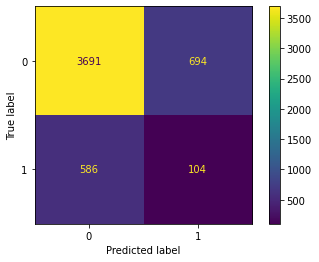

In [ ]:
def get_confusion_matrix(user_summary,machine_summary):
  machine_summary = machine_summary.astype(np.float32)
  user_summary = user_summary.astype(np.float32)
  n_users, n_frames = user_summary.shape

  # binarization
  machine_summary[machine_summary > 0] = 1
  user_summary[user_summary > 0] = 1

  if len(machine_summary) > n_frames:
      machine_summary = machine_summary[:n_frames]
  elif len(machine_summary) < n_frames:
      zero_padding = np.zeros((n_frames - len(machine_summary)))
      machine_summary = np.concatenate([machine_summary, zero_padding])

  gt_summary = user_summary[0, :]    
  cm = confusion_matrix(gt_summary, machine_summary)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  disp.plot()
  plt.show()

  return cm

user_summary = user_summary_dataset["video_6"]['user_summary'][...]
cm = get_confusion_matrix(user_summary, summaries[0])

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
clf = SVC(random_state=0)

In [ ]:
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

#Tek video için özet çalışması

In [ ]:
def single_prepare(dataset):

  # splits sequnence of frame features and other datas for single video (Ekstra olarak outputa length ekledim frame featurelarının boyutunu temsil ediyor)
  
  seq_idx = 0
  temp = 0
  datas = []
  flag = []
  seq_size = 0
  video = []
  key = "video_1"



  seq = dataset[key]['features'][...]
  length = seq.shape[0]
  seq_size += int(seq.shape[0] / 400) + 1

  data_seq = np.zeros((seq_size,400,512))    

  num_frames = dataset[key]['n_frames'][()]
  cps = dataset[key]['change_points'][...]
  nfps = dataset[key]['n_frame_per_seg'][...].tolist()
  positions = dataset[key]['picks'][...]
  fps = dataset[key]['fps']
  seq_split = np.vsplit(seq,[400])  
  

  while seq_split[-1].shape[0] > 400:
    seq_split_temp = np.vsplit(seq_split[-1], [400])
    seq_split = np.delete(seq_split,-1)
    seq_split = np.concatenate((seq_split,seq_split_temp))

  count = 0
  video = []
  temp = 0

  if seq_split[1].shape[0] != 0:
    
    
    len_cps = len(cps)
    len_nfps = len(nfps)
    len_positions = len(positions)

    while int(seq_split[count].shape[0] / 400) != 0:

      partian = 400/int(seq.shape[0])

      current,next = temp,partian+temp
      video_partian = {}
      n_frames = int(num_frames * partian)
      
      cps_cur,cps_next = int(len_cps*current),int(len_cps*next)

      change_points = cps[cps_cur:cps_next] 
      nfps_cur,nfp_next = int(len_nfps*current),int(len_nfps*next)
      n_frame_per_seg = nfps[nfps_cur:nfp_next]
      position_current,position_next = int(len_positions*current),int(len_positions*next)
      position = positions[position_current:position_next]
      temp += partian
      
      video_partian["n_frames"] = n_frames
      video_partian["change_points"] = change_points
      video_partian["n_frame_per_seg"] = n_frame_per_seg
      video_partian["picks"] = position

      video.append(video_partian)
      
      seq_split[count]= np.resize(seq_split[count],(400,512))
      data_seq[seq_idx] = seq_split[count]
      count += 1
      seq_idx += 1



    partian =seq_split[-1].shape[0]/int(seq.shape[0])
    
    current,next = temp,partian+temp
    video_partian = {}
    num_frames_partian = int(num_frames * partian)
    
    cps_cur,cps_next = int(len_cps*current),int(len_cps*next)
    change_points = cps[cps_cur:]

    nfps_cur,nfp_next = int(len_nfps*current),int(len_nfps*next)
    n_frame_per_seg = nfps[nfps_cur:]

    position_current,position_next = int(len_positions*current),int(len_positions*next)
    position = positions[position_current:]


    video_partian["n_frames"] = num_frames_partian
    video_partian["change_points"] = change_points
    video_partian["n_frame_per_seg"] = n_frame_per_seg
    video_partian["picks"] = position

    video.append(video_partian)
    datas.append(video)
    datas.append(fps)
    seq_split[-1]= np.resize(seq_split[-1],(400,512))
    data_seq[count] = seq_split[-1]
    count += 1
  else:
      seq_split[0]= np.resize(seq_split[0],(400,512))
      data_seq[seq_idx] = seq_split[0]
      video_partian = {}
      video_partian["n_frames"] = num_frames
      video_partian["change_points"] = cps
      video_partian["n_frame_per_seg"] = nfps
      video_partian["picks"] = positions
      video.append(video_partian)
      datas.append(video)

  return data_seq,datas,length

data_seq,datas,length = single_prepare(dataset)

In [ ]:
def single_video(data_seq, datas, model):


  if length > 400:
    size = len(datas[0])
    machine_summary = concatenate_video_summarization(0, size,data_seq, 0, datas, model)

  else:
    cps = datas[0][0]['change_points']
    num_frames = datas[0][0]['n_frames']
    nfps = datas[0][0]['n_frame_per_seg']
    positions = datas[0][0]['picks']

    predictions = model.predict(data_seq, verbose = 1)
    probs = np.squeeze(predictions)
    machine_summary = generate_summary(probs, cps, num_frames, nfps, positions, proportion=0.20, method='knapsack')




  return machine_summary

machine_summary = single_video(data_seq, datas, model)

1/1 [==============================] - 3s 3s/step


In [ ]:
def extract_sound_in_summary(video_dir, sound_dir, summary):
  clips = []
  end = -1
  idx = 0
  size = len(summary) 
  name_count = 0


  while size > idx:
    clip = []
    
    while size > idx and summary[idx] == 1.0 :
      clip.append(idx)
      idx += 1

    if summary[idx-1] == 1.0:
      clips.append(clip)
      
    idx += 1 

  for clip in clips:
    if len(clip) > 10:
      video_capture = cv2.VideoCapture(video_dir)
      fps = video_capture.get(cv2.CAP_PROP_FPS)
      sound_name = str(name_count).zfill(3) + '.wav'
      sound_path = os.path.join(sound_dir, sound_name)
      start = clip[0] / fps
      end = clip[-1] / fps
      print(start,end)
      clip = mp.VideoFileClip(video_dir)
      clip = clip.subclip(start, end)
      clip.audio.write_audiofile(sound_path)
      name_count += 1
    else:
      for frames_idx in clip:
        summary[frames_idx] = 0.0

  return summary

In [ ]:
summary = extract_sound_in_summary("/content/drive/MyDrive/video/denemeTest.mp4", "/content/drive/MyDrive/video", machine_summary )

# Frameleri birleştirme işlemi ile video oluşturma



In [ ]:
import cv2

def frm2video(frm_dir, summary, vid_writer):
    for idx, val in enumerate(summary):
        
        if val == 1.0:
            frm_name = str(idx).zfill(5) + '.jpg'
            frm_path = os.path.join(frm_dir, frm_name)
            frm = cv2.imread(frm_path)
            frm = cv2.resize(frm, (640, 480))
            vid_writer.write(frm)




frm_dir = "/content/drive/MyDrive/summe/frames/deneme2"
video_dir = "/content/"
video_name = "demo.mp4"

vid_writer = cv2.VideoWriter(
        os.path.join(video_dir, video_name),
        cv2.VideoWriter_fourcc(*'MP4V'),
        30,
        (640, 480),
    )

frm2video(frm_dir,machine_summary,vid_writer)
vid_writer.release()